In [52]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight

In [33]:
# --- 1. Load and Merge Data ---

# Load data
train_transaction = pd.read_csv('../input/train_transaction.csv')
train_identity = pd.read_csv('../input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
y_check = train_df['isFraud']

In [ ]:
# Convert object columns to 'category' type (XGBoost handles this natively now)
# Or simple Ordinal Encoding for the check
# for col in X_check.select_dtypes(include=['object']):
#     X_check[col] = X_check[col].astype('category')

In [34]:

X_subset, _, y_subset, _ = train_test_split(
    X_check, 
    y_check, 
    train_size=100000, 
    stratify=y_check, 
    random_state=42
)

In [35]:
for col in X_subset.select_dtypes(include=['object']).columns:
    X_subset[col] = X_subset[col].astype('category')
# Print check
print(f"Subset shape: {X_subset.shape}")
print(f"Frauds in subset: {y_subset.sum()} (Should be approx 3500)")

Subset shape: (100000, 431)
Frauds in subset: 3499 (Should be approx 3500)


In [36]:
# 2. Run a fast, small model
# enable_categorical=True works in newer XGBoost versions
clf = XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.1, 
    tree_method='hist', # Much faster for large data
    enable_categorical=True,
    n_jobs=-1
)

clf.fit(X_subset, y_subset)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# --- C. Extract Top Features ---
# We use "Total Gain" - the best metric for importance
importance = clf.get_booster().get_score(importance_type='total_gain')

# Sort and keep top 100
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
TOP_FEATURES = [x[0] for x in sorted_features[:100]]

print(f"\nTop 10 features selected: {TOP_FEATURES[:10]}")
print(f"Total features kept: {len(TOP_FEATURES)}")


Top 10 features selected: ['V258', 'C1', 'C14', 'V201', 'R_emaildomain', 'DeviceInfo', 'C13', 'D2', 'C8', 'P_emaildomain']
Total features kept: 100


In [38]:
CAT_COLS = ['R_emaildomain', 'DeviceInfo', 'DeviceType', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'dist1', 'dist2', 'id_31', 'id_30', 'M5', 'M7', 'M8', 'M9', 'V258', 'C1', 'C14', 'V201', 'C13', 'C8', 'D2', 'V317']

In [39]:
cols_to_use = TOP_FEATURES + ['isFraud', 'TransactionDT']
df_clean = train_df[cols_to_use].copy()

cat_cols_final = [c for c in TOP_FEATURES if c in CAT_COLS] # Uses your list from earlier
num_cols_final = [c for c in TOP_FEATURES if c not in cat_cols_final]

In [40]:
for col in cat_cols_final:
    df_clean[col] = df_clean[col].astype(str).fillna("Missing_Category")
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    # Store vocab size for the Embedding Layer later
    df_clean[col] = df_clean[col].astype('int32')

In [41]:
scaler = StandardScaler()

# Fill NaNs first
df_clean[num_cols_final] = df_clean[num_cols_final].fillna(0)

In [43]:
real_cat_cols = df_clean[TOP_FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()
real_num_cols = df_clean[TOP_FEATURES].select_dtypes(include=['number']).columns.tolist()

In [46]:
cat_cols_final = real_cat_cols
num_cols_final = real_num_cols

print(f"Correction complete.")
print(f"Categorical columns found: {len(cat_cols_final)} (e.g., {cat_cols_final})")
print(f"Numerical columns found:   {len(num_cols_final)} (e.g., {num_cols_final})")

Correction complete.
Categorical columns found: 8 (e.g., ['P_emaildomain', 'id_33', 'card6', 'ProductCD', 'card4', 'M4', 'M6', 'M2'])
Numerical columns found:   92 (e.g., ['V258', 'C1', 'C14', 'V201', 'R_emaildomain', 'DeviceInfo', 'C13', 'D2', 'C8', 'V317', 'V308', 'V90', 'TransactionAmt', 'V91', 'id_31', 'C11', 'V187', 'C4', 'id_30', 'V294', 'V189', 'V315', 'card3', 'D3', 'V281', 'C12', 'D15', 'card2', 'V152', 'card1', 'D8', 'V283', 'V62', 'C6', 'V225', 'addr1', 'V45', 'D10', 'card5', 'V87', 'V332', 'V103', 'id_17', 'id_09', 'V48', 'V82', 'D1', 'V54', 'V156', 'V53', 'V102', 'V279', 'V12', 'V175', 'V296', 'V261', 'V29', 'C2', 'V323', 'D11', 'V95', 'V49', 'V165', 'V94', 'D4', 'V55', 'id_20', 'M5', 'C9', 'C10', 'V67', 'id_01', 'V99', 'V313', 'V133', 'V310', 'id_02', 'V312', 'V129', 'V126', 'V210', 'V218', 'V314', 'V169', 'D13', 'V264', 'V295', 'V326', 'D5', 'D14', 'V289', 'V70'])


In [47]:
for col in cat_cols_final:
    # Fill missing
    df_clean[col] = df_clean[col].astype(str).fillna("Missing_Category")
    # Encode
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    df_clean[col] = df_clean[col].astype('int32')

In [48]:
# B. Process Numerical (Scale)
# NOW this will work because we removed the emails from this list
scaler = StandardScaler()

# Fill NaNs with 0
df_clean[num_cols_final] = df_clean[num_cols_final].fillna(0)

# Scale
df_clean[num_cols_final] = scaler.fit_transform(df_clean[num_cols_final])
print(f"Final shape: {df_clean.shape}")

Final shape: (590540, 102)


In [49]:
df_clean = df_clean.sort_values('TransactionDT')
final_data = df_clean.drop('TransactionDT', axis=1)

# Split first 80% / last 20%
split_idx = int(len(final_data) * 0.8)

In [50]:
train_data = final_data.iloc[:split_idx]
val_data = final_data.iloc[split_idx:]

# Separate X and y
X_train = train_data.drop('isFraud', axis=1)
y_train = train_data['isFraud']

X_val = val_data.drop('isFraud', axis=1)
y_val = val_data['isFraud']

print(f"Train samples: {len(X_train)} (Fraud rate: {y_train.mean():.4f})")
print(f"Val samples:   {len(X_val)}   (Fraud rate: {y_val.mean():.4f})")

Train samples: 472432 (Fraud rate: 0.0351)
Val samples:   118108   (Fraud rate: 0.0344)


In [53]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.5182073259285748, 1: 14.230736791372975}


In [54]:
def build_model(train_df, cat_cols, num_cols):
    inputs = {}
    encoded_features = []

    # 1. Handle Numerical Inputs
    for col in num_cols:
        # Define Input
        input_layer = layers.Input(shape=(1,), name=col)
        inputs[col] = input_layer
        encoded_features.append(input_layer)

    # 2. Handle Categorical Inputs (Embeddings)
    for col in cat_cols:
        input_layer = layers.Input(shape=(1,), name=col)
        inputs[col] = input_layer

        # Calculate Vocab Size (Max ID + small buffer)
        # We look at max value in train to determine size
        vocab_size = int(train_df[col].max()) + 5 
        
        # Rule of thumb: Embedding size = min(50, vocab/2)
        embed_dim = min(50, (vocab_size + 1) // 2)

        # Create Embedding
        emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(input_layer)
        emb = layers.Flatten()(emb)
        encoded_features.append(emb)

    # 3. Concatenate (Merge)
    all_features = layers.concatenate(encoded_features)

    # 4. Deep Learning Layers
    x = layers.Dense(256, activation='relu')(all_features)
    x = layers.BatchNormalization()(x) # Stabilizes training
    x = layers.Dropout(0.3)(x)         # Prevents overfitting

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    
    # 5. Output Layer (Probability 0.0 to 1.0)
    output = layers.Dense(1, activation='sigmoid', name='fraud_prob')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

In [55]:
# --- B. Compile the Model ---
# Clear any old models from memory
tf.keras.backend.clear_session()

# Build it using your lists
model = build_model(X_train, cat_cols_final, num_cols_final)

metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=metrics
)

In [56]:
def dataframe_to_dict(df):
    return {col: df[col].values for col in df.columns}

train_inputs = dataframe_to_dict(X_train)
val_inputs = dataframe_to_dict(X_val)

In [57]:
print("Starting Training...")

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=20,          
    batch_size=2048,     # Large batch size is faster for tabular data
    class_weight=class_weights, # Handle the imbalance
    callbacks=[
        # Stop if model stops improving for 5 epochs
        callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
        # Lower learning rate if stuck
        callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, verbose=1)
    ]
)

Starting Training...
Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - auc: 0.8399 - loss: 0.4940 - precision: 0.1160 - recall: 0.7261 - val_auc: 0.8535 - val_loss: 0.3972 - val_precision: 0.1406 - val_recall: 0.7023 - learning_rate: 0.0010
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.8755 - loss: 0.4380 - precision: 0.1421 - recall: 0.7630 - val_auc: 0.8645 - val_loss: 0.3567 - val_precision: 0.1517 - val_recall: 0.7035 - learning_rate: 0.0010
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.8858 - loss: 0.4204 - precision: 0.1475 - recall: 0.7746 - val_auc: 0.8671 - val_loss: 0.3484 - val_precision: 0.1660 - val_recall: 0.6959 - learning_rate: 0.0010
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - auc: 0.8950 - loss: 0.4051 - precision: 0.1563 - recall: 0.7889 - val_auc: 0.8661 - val_loss: 0.3060 - val_precision: 0.1810 - val_recall: 0.6622 - learning_rate: 0.0010
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - auc: 0.9014 - loss: 0.3

In [58]:
# Get probabilities (0.0 to 1.0)
preds = model.predict(val_inputs)

# Set your "Warning" Threshold (e.g., 20% doubt)
# Anything above 0.20 gets flagged
WARNING_THRESHOLD = 0.20 

# Create the warnings
# Flatten preds to a 1D array
warnings = (preds.flatten() > WARNING_THRESHOLD).astype(int)

print(f"Total Transactions: {len(warnings)}")
print(f" flagged as Potential Fraud (Risk > {WARNING_THRESHOLD}): {sum(warnings)}")

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
Total Transactions: 118108
 flagged as Potential Fraud (Risk > 0.2): 36130


In [63]:
# The history.history dictionary holds lists of all scores
train_auc = history.history['auc']
val_auc = history.history['val_auc']

# Find the maximum score achieved
best_score = max(val_auc)
best_epoch = val_auc.index(best_score) + 1

print(f"--- Best Result ---")
print(f"Best Validation AUC (ROC): {best_score:.5f}")
print(f"Achieved at Epoch:         {best_epoch}")

--- Best Result ---
Best Validation AUC (ROC): 0.88583
Achieved at Epoch:         12


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step


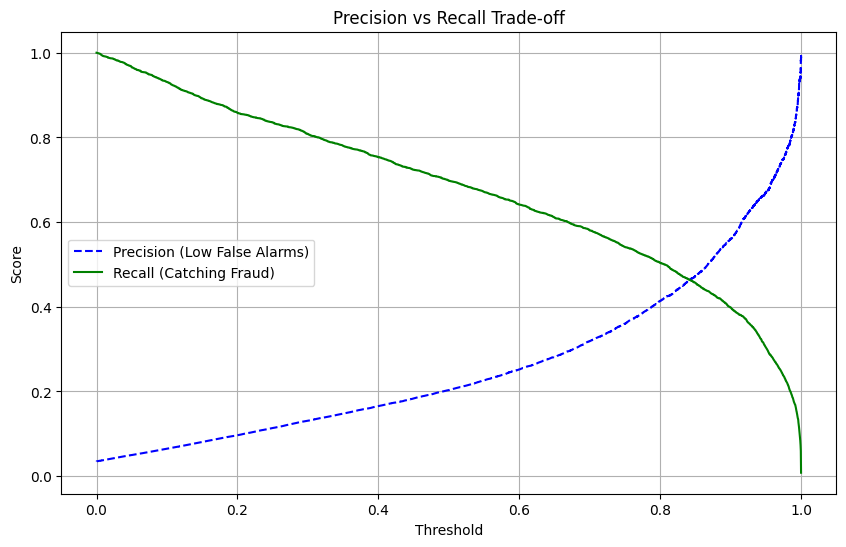

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1. Get predictions from the Validation Set
# (Make sure to use val_inputs from the previous step)
preds = model.predict(val_inputs)

# 2. Calculate Precision & Recall for ALL possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, preds)

# 3. Plot the Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision (Low False Alarms)')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Catching Fraud)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall Trade-off')
plt.legend()
plt.grid(True)
plt.show()

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step
--- Optimal Threshold Found ---
Best Threshold: 0.8851
Max F1 Score:   0.4704
At this point:
 - Recall:    41.98% (Fraud caught)
 - Precision: 53.50% (Correct flags)


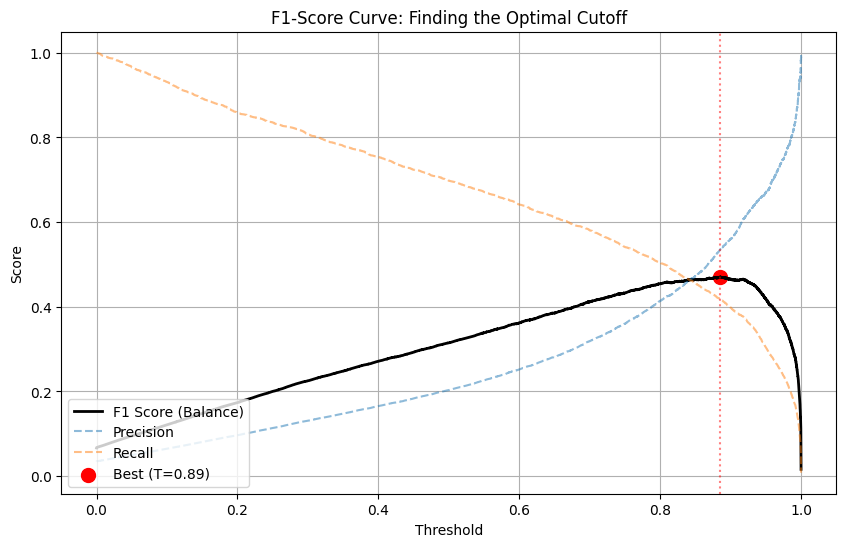

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Get predictions (probabilities) on Validation Set
# Ensure you are using val_inputs and y_val from your previous steps
y_prob = model.predict(val_inputs).flatten()
y_true = y_val.values

# 2. Calculate Precision and Recall for all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

# 3. Calculate F1 Score for each threshold
# Note: precisions and recalls have 1 extra element (0/1), so we slice [:-1] to match thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1] # Remove last element to match thresholds length

# 4. Find the "Best" Threshold (Max F1)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_recall = recalls[best_idx]
best_precision = precisions[best_idx]

print(f"--- Optimal Threshold Found ---")
print(f"Best Threshold: {best_thresh:.4f}")
print(f"Max F1 Score:   {best_f1:.4f}")
print(f"At this point:")
print(f" - Recall:    {best_recall:.2%} (Fraud caught)")
print(f" - Precision: {best_precision:.2%} (Correct flags)")

# 5. Plot the Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score (Balance)', color='black', linewidth=2)
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', alpha=0.5)
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='--', alpha=0.5)

# Highlight the peak
plt.scatter(best_thresh, best_f1, color='red', s=100, label=f'Best (T={best_thresh:.2f})')
plt.axvline(best_thresh, color='red', linestyle=':', alpha=0.5)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score Curve: Finding the Optimal Cutoff')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [61]:
TARGET_RECALL = 0.75

# 2. Find the threshold that guarantees this recall
# (Using the precisions, recalls, thresholds variables from your previous run)
idx = (np.abs(recalls - TARGET_RECALL)).argmin()

op_threshold = thresholds[idx]
op_precision = precisions[idx]
op_f1 = 2 * (op_precision * TARGET_RECALL) / (op_precision + TARGET_RECALL)

print(f"--- Business Requirement: Catch {TARGET_RECALL:.0%} of Fraud ---")
print(f"Required Threshold: {op_threshold:.4f}")
print(f"Resulting Precision: {op_precision:.2%}")
print(f"Resulting F1-Score:  {op_f1:.4f}")

--- Business Requirement: Catch 75% of Fraud ---
Required Threshold: 0.4068
Resulting Precision: 16.77%
Resulting F1-Score:  0.2741


In [62]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# --- 1. Train XGBoost on the SAME data ---
print("Training XGBoost...")

# XGBoost works best with its own optimized data structure (DMatrix)
# We use enable_categorical=True so we don't need to do complex encoding
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

# Parameters optimized for IEEE-CIS Dataset
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',          # We optimize for the Competition Metric!
    'eta': 0.05,                   # Learning rate
    'max_depth': 9,                # Deep trees for complex fraud patterns
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',         # Fast training
    'device': 'cuda'               # Use GPU if available (change to 'cpu' if not)
}

# Train
xgb_model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000, 
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

# --- 2. Make Predictions ---
print("Generating Ensemble Predictions...")

# Get Probabilities from XGBoost
xgb_pred_val = xgb_model.predict(dval)

# Get Probabilities from TensorFlow (Ensure this is flattened!)
nn_pred_val = model.predict(val_inputs).flatten()

# --- 3. Blend (Ensemble) ---
# We give them equal weight (0.5 / 0.5)
ensemble_pred = (0.5 * xgb_pred_val) + (0.5 * nn_pred_val)

# --- 4. Compare Results ---
xgb_auc = roc_auc_score(y_val, xgb_pred_val)
nn_auc = roc_auc_score(y_val, nn_pred_val)
ens_auc = roc_auc_score(y_val, ensemble_pred)

print(f"\n--- AUC Scoreboard ---")
print(f"TensorFlow Only: {nn_auc:.5f}")
print(f"XGBoost Only:    {xgb_auc:.5f}")
print(f"ENSEMBLE (Mix):  {ens_auc:.5f}  <-- This is your new Score")

Training XGBoost...


c:\Users\Marek\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\Marek\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.82219	val-auc:0.79439
[50]	train-auc:0.91958	val-auc:0.88023
[100]	train-auc:0.95034	val-auc:0.90005
[150]	train-auc:0.96310	val-auc:0.90851
[200]	train-auc:0.97145	val-auc:0.91419
[250]	train-auc:0.97611	val-auc:0.91596
[300]	train-auc:0.98015	val-auc:0.91727
[350]	train-auc:0.98336	val-auc:0.91782
[400]	train-auc:0.98584	val-auc:0.91793
[412]	train-auc:0.98640	val-auc:0.91825
Generating Ensemble Predictions...
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step

--- AUC Scoreboard ---
TensorFlow Only: 0.88587
XGBoost Only:    0.91824
ENSEMBLE (Mix):  0.89898  <-- This is your new Score
